# Personalized User-level DP

In [1]:
from autodp import rdp_acct
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

import os
path_project = os.path.dirname(os.path.abspath('.'))
import sys
sys.path.append(os.path.join(path_project, 'src'))
sys.path.append(os.path.join(path_project, 'exp/script'))

import options

img_path = os.path.join(path_project, 'exp', 'img')
pickle_path = os.path.join(path_project, 'exp', 'pickle')
results_path = os.path.join(path_project, 'exp', 'results')
default_args = options.build_default_args(path_project)

import copy
from run_simulation import run_simulation

from mylogger import logger_set_debug, logger_set_info, logger_set_warning
from opacus.accountants import RDPAccountant

import pickle

def RDP_gaussian_with_C(sigma, alpha, C):
    assert(sigma > 0)
    assert(alpha >= 0)
    return 0.5 * C**2 / sigma ** 2 * alpha

### utils

In [2]:
Q_LIST_SIZE = 30

# binary search given q_u
def from_q_u(q_u, delta, epsilon_u, sigma, T, m=100, precision=1e-6):
    max_sensitivity_u = 100
    min_sensitivity_u = 0
    while True:
        sensitivity_u = (max_sensitivity_u + min_sensitivity_u) / 2
        # func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
        # accountant = rdp_acct.anaRDPacct(m=m)
        accountant = RDPAccountant()
        for i in range(T):
            accountant.step(noise_multiplier=sigma/sensitivity_u, sample_rate=q_u)
            # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        # eps = accountant.get_eps(delta)
        eps = accountant.get_epsilon(delta=delta)
        if eps < epsilon_u:
            min_sensitivity_u = sensitivity_u
        else:
            max_sensitivity_u = sensitivity_u
        if 0 < epsilon_u - eps and epsilon_u - eps < precision:
            return sensitivity_u, eps


# binary search given_sensitivity_u
def from_sensitivity_u(sensitivity_u, delta, epsilon_u, sigma, T, m=100, precision=1e-6):
    max_q_u = 1.0
    min_q_u = 0
    # func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
    while True:
        q_u = (max_q_u + min_q_u) / 2
        # accountant = rdp_acct.anaRDPacct(m=m)
        accountant = RDPAccountant()
        for i in range(T):
            # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
            accountant.step(noise_multiplier=sigma/sensitivity_u, sample_rate=q_u)
        # eps = accountant.get_eps(delta)
        eps = accountant.get_epsilon(delta=delta)
        if eps < epsilon_u:
            min_q_u = q_u
        else:
            max_q_u = q_u
        if 0 < epsilon_u - eps and epsilon_u - eps < precision:
            return q_u, eps
        

# qCカーブを書くために，適当にqを選んでCを計算して点をプロットする
def make_q_c_curve(epsilon_u, delta, sigma, n_round=100, num_points=20, min=-5):
    T = n_round

    num_points = num_points // 3 * 2
    x = np.logspace(min, -1, num_points).tolist() + np.linspace(0.15, 1.0, int(num_points/2)).tolist()
    y = []
    for q_u in x:
        sensitivity_u, eps = from_q_u(q_u=q_u, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
        assert eps <= epsilon_u, f"eps={eps} > epsilon_u={epsilon_u}"
        # print("sensitivity_u =", sensitivity_u, "eps =", eps)
        y.append(sensitivity_u)
    return x, y


def plot_q_c_curve(x, y, title="", log=True):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)
    ax.plot(x, y, marker='o', label='sensitivity_u')
    for i, (xi, yi) in enumerate(zip(x, y)):
        if i % 5 == 0:
            ax.annotate(f"({xi:.5f}, {yi:.5f})", (xi, yi), textcoords="offset points", xytext=(0,10), ha='center')
    # q*C の値をプロット
    ax.plot(x, np.array(x)*np.array(y), marker='x', linestyle='--', color='red', label='product_x*y')
    print("Max idx", np.argmax(np.array(x)*np.array(y)))
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
    ax.set_xlabel("q_u")
    ax.set_ylabel("sensitivity_u")
    ax.set_title(title)
    plt.show()


def make_static_params(epsilon_u_dct, delta, sigma, n_round, idx_per_group, q_step_size):
    """
    Need to specify idx and q_step_size
    """
    C_u_dct = {}
    q_u_dct = {}

    C_and_q_per_group = {}
    for group_eps, idx in idx_per_group.items():
        n_of_q_u = Q_LIST_SIZE
        q_u_list = []
        init_q_u = 1.0
        for _ in range(n_of_q_u):
            q_u_list.append(init_q_u)
            init_q_u *= q_step_size
        q_u = q_u_list[idx]
        C_u, _eps = from_q_u(q_u=q_u, delta=delta, epsilon_u=group_eps, sigma=sigma, T=n_round)
        assert _eps <= group_eps, f"_eps={_eps} > eps_u={group_eps}"
        C_and_q_per_group[group_eps] = (C_u, q_u)

    for user_id, eps_u in epsilon_u_dct.items():
        C_u, q_u = C_and_q_per_group[eps_u]
        C_u_dct[user_id] = C_u
        q_u_dct[user_id] = q_u

    return C_u_dct, q_u_dct


def fed_simulation(
    delta, 
    sigma, 
    n_users, 
    C_u=None, 
    q_u=None, 
    q_step_size=None,
    times=1, 
    user_dist="uniform-iid", 
    silo_dist="uniform", 
    dataset_name="light_mnist", 
    global_learning_rate=10.0, 
    clipping_bound=1.0,
    n_round=10, 
    local_epochs=50, 
    local_learning_rate=0.01,
    agg_strategy="PULDP-AVG",
    epsilon_u=None,
    group_thresholds=None,
    validation_ratio=0.0,
    with_momentum=None,
    train_loss_dp=None,
    sigma_for_online_optimization=1.0,
    total_dp_eps_for_online_optimization=None,
    hp_baseline=None,
):
    args = options.build_default_args(path_project)

    if dataset_name == "heart_disease":
        from flamby_utils.heart_disease import update_args

        args = update_args(args)

    elif dataset_name == "tcga_brca":
        from flamby_utils.tcga_brca import update_args

        args = update_args(args)

    args.dataset_name = dataset_name
    args.agg_strategy = agg_strategy
    args.n_total_round = n_round
    args.n_users = n_users
    args.local_epochs = local_epochs
    args.times = times

    args.user_dist = user_dist
    args.silo_dist = silo_dist
    args.global_learning_rate = global_learning_rate
    args.local_learning_rate = local_learning_rate
    args.clipping_bound = clipping_bound
    args.with_momentum = with_momentum
    args.train_loss_dp = train_loss_dp
    args.momentum_weight = q_step_size
    args.sigma_for_online_optimization = sigma_for_online_optimization
    args.total_dp_eps_for_online_optimization = total_dp_eps_for_online_optimization
    args.hp_baseline = hp_baseline

    args.delta = delta
    args.sigma = sigma
    args.C_u = C_u
    args.q_u = q_u
    args.q_step_size = q_step_size
    args.epsilon_u = epsilon_u
    args.group_thresholds = group_thresholds
    args.dry_run = False
    args.secure_w = False

    args.validation_ratio = validation_ratio
    # args.client_optimizer = "sgd"
    args.client_optimizer = "adam"

    results_list = []
    for i in range(args.times):
        print("======== TIME:", i, "start")
        args.seed = args.seed + i
        # try:
        sim_results = run_simulation(args, path_project)
        results_list.append(sim_results)
        # except AssertionError:
        #     results_list.append("Assertion Error")

    return results_list


def calc_metric(results, symbol="test"):
    if symbol == "train":
        acc_list = np.array([r['train'][f'train_metric'] for r in results])
        loss_list = np.array([r['train'][f'train_loss'] for r in results])
    else:
        acc_list = np.array([r['global'][f'global_{symbol}'][-1][1] for r in results])
        loss_list = np.array([r['global'][f'global_{symbol}'][-1][2] for r in results])
    acc_mean, acc_std, loss_mean, loss_std = np.mean(acc_list), np.std(acc_list), np.mean(loss_list), np.std(loss_list)
    return acc_mean, acc_std, loss_mean, loss_std


def make_epsilon_u(epsilon=1.0, n_users=0, dist="homo", epsilon_list=[], ratio_list=[], random_state: np.random.RandomState=None) -> dict[int, float]:
    if dist == "homo":
        epsilon_u = {user_id: epsilon for user_id in range(n_users)}
    elif dist == "hetero":
        assert len(epsilon_list) > 0 and len(ratio_list) > 0
        epsilon_u_list = random_state.choice(epsilon_list, size=n_users, p=ratio_list)
        epsilon_u = {user_id: epsilon_u_list[user_id] for user_id in range(n_users)}
    else:
        raise ValueError(f"invalid dist {dist}")
    return epsilon_u

def group_by_closest_below(epsilon_u_dct: dict, group_thresholds: list):
    minimum = min(epsilon_u_dct.values())
    group_thresholds = set(group_thresholds) | {minimum}
    grouped = {
        g: [] for g in group_thresholds
    }  # Initialize the dictionary with empty lists for each group threshold
    for key, value in epsilon_u_dct.items():
        # Find the closest group threshold that is less than or equal to the value
        closest_group = max([g for g in group_thresholds if g <= value], default=None)
        # If a suitable group is found, append the key to the corresponding list
        if closest_group is not None:
            grouped[closest_group].append(key)

    return grouped


## STATIC MANUAL OPTIMIZATION

def prepare_grid_search(epsilon_u, start_idx: int, end_idx: int):
    # set idx list for each group
    group_eps_set = set(epsilon_u.values())
    idx_per_group_list = []

    idx_list = list(range(Q_LIST_SIZE))[start_idx:end_idx]
    idx_list_list = [idx_list for _ in range(len(group_eps_set))]

    for combination in itertools.product(*idx_list_list):
        idx_per_group = {}
        for idx, group_eps in zip(combination, group_eps_set):
            idx_per_group[group_eps] = idx
        idx_per_group_list.append(idx_per_group)

    return {"name": "grid", "params": {"idx_per_group_list": idx_per_group_list}}


def prepare_random_search(epsilon_u, start_idx: int, end_idx: int, random_state: np.random.RandomState, n_samples: int):
    # set idx list for each group``
    group_eps_set = set(epsilon_u.values())
    idx_per_group_list = []

    idx_list = list(range(Q_LIST_SIZE))[start_idx:end_idx]
    idx_list_list = [idx_list for _ in range(len(group_eps_set))]
    all_candidates = itertools.product(*idx_list_list)
    samples = random_state.choice(len(all_candidates), size=n_samples, replace=False)

    for sample in samples:
        idx_per_group = {}
        for idx, group_eps in zip(all_candidates[sample], group_eps_set):
            idx_per_group[group_eps] = idx
        idx_per_group_list.append(idx_per_group)

    return {"name": "random", "params": {"idx_per_group_list": idx_per_group_list}}


def prepare_independent_search(epsilon_u, start_idx: int, end_idx: int):
    # set idx list for each group
    group_eps_set = set(epsilon_u.values())
    idx_per_group_list = []
    idx_list = list(range(Q_LIST_SIZE))[start_idx:end_idx]

    for group_eps in group_eps_set:
        for idx in idx_list:
            idx_per_group = {}
            idx_per_group[group_eps] = idx
            for group_eps in group_eps_set:
                if group_eps != group_eps:
                    idx_per_group[group_eps] = int((start_idx + end_idx) / 2)
        idx_per_group_list.append(idx_per_group)

    return {"name": "independent", "params": {"idx_per_group_list": idx_per_group_list}}


def static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy: dict, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.0):
    try:
        prefix_epsilon_u = list(epsilon_u.items())[:4]
        with open(os.path.join(pickle_path, f'static_optimization_{sigma}_{delta}_{n_users}_{n_round}_{dataset_name}_{q_step_size}_{opt_strategy["name"]}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'rb') as file:
            results_dict = pickle.load(file)
    except FileNotFoundError:
        results_dict = {}

    if opt_strategy["name"] in ["grid", "random", "independent"]:
        # grid search
        for idx_per_group in opt_strategy["params"]["idx_per_group_list"]:
            print("IDX: ", idx_per_group)
            C_u, q_u = make_static_params(epsilon_u, delta, sigma, n_round, idx_per_group=idx_per_group, q_step_size=q_step_size)
            result = fed_simulation(
                delta, sigma, n_users, C_u=C_u, q_u=q_u, agg_strategy="PULDP-AVG",
                times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
                global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
                local_epochs=local_epochs, epsilon_u=epsilon_u, validation_ratio=validation_ratio,
            )
            results_dict[str(idx_per_group)] = (q_u, C_u, result)
    else:
        raise ValueError(f"invalid opt_strategy {opt_strategy}")
    
    with open(os.path.join(pickle_path, f'static_optimization_{sigma}_{delta}_{n_users}_{n_round}_{dataset_name}_{q_step_size}_{opt_strategy["name"]}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'wb') as file:
        pickle.dump(results_dict, file)


def show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy: dict, validation_ratio=0.0, train_loss=False, errorbar=True):
    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'static_optimization_{sigma}_{delta}_{n_users}_{n_round}_{dataset_name}_{q_step_size}_{opt_strategy["name"]}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'rb') as file:
        results_dict = pickle.load(file)

    plt.figure(figsize=(8, 3)) 
    x = list(results_dict.keys())
    q_u_list = [results_dict[i][0][0] for i in x]
    C_u_list = [results_dict[i][1][0] for i in x]
    acc_mean_acc_std_loss_mean_loss_std = [calc_metric(results_dict[i][2], "test") for i in x]
    y = [acc_mean_acc_std_loss_mean_loss_std[i][2] for i in range(len(x))]  # loss_mean
    error = [acc_mean_acc_std_loss_mean_loss_std[i][3] for i in range(len(x))]  # loss_std
    plt.title('Test Loss Mean with Standard Deviation over different idx')
    plt.ylabel('Test Loss Mean')
    if errorbar:
        plt.errorbar(x, y, yerr=error, fmt='-o')
    else:
        plt.plot(x, y, '-o')
    for i in range(len(x)):
        plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=8)
    plt.xlabel('idx')

    ax2 = plt.twinx()
    y_metric = [acc_mean_acc_std_loss_mean_loss_std[i][0] for i in range(len(x))]  # acc_mean
    error_metric = [acc_mean_acc_std_loss_mean_loss_std[i][1] for i in range(len(x))]  # acc_std
    if errorbar:
        ax2.errorbar(x, y_metric, yerr=error_metric, fmt='-o', color='red', label='Accuracy')
    else:
        ax2.plot(x, y_metric, '-o', color='red', label='Accuracy')
    
    plt.show()

    # optimize for test loss, not for validation loss!
    min_idx, min_test_loss = x[np.argmin(y)], np.min(y)

    if train_loss:
        plt.figure(figsize=(8, 3))
        x = list(results_dict.keys())
        q_u_list = [results_dict[i][0][0] for i in x]
        C_u_list = [results_dict[i][1][0] for i in x]
        acc_mean_acc_std_loss_mean_loss_std = [calc_metric(results_dict[i][2], "train") for i in x]
        y = [acc_mean_acc_std_loss_mean_loss_std[i][2] for i in range(len(x))]  # loss_mean
        error = [acc_mean_acc_std_loss_mean_loss_std[i][3] for i in range(len(x))]  # loss_std
        if errorbar:
            plt.errorbar(x, y, yerr=error, fmt='-o')
        else:
            plt.plot(x, y, '-o')
        for i in range(len(x)):
            plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=8)
        plt.title('Train Loss Mean with Standard Deviation over different idx')
        plt.xlabel('idx')
        plt.ylabel('Train Loss Mean')
        plt.legend(loc='upper right')

        ax2 = plt.twinx()
        y_metric = [acc_mean_acc_std_loss_mean_loss_std[i][0] for i in range(len(x))]  # acc_mean
        error_metric = [acc_mean_acc_std_loss_mean_loss_std[i][1] for i in range(len(x))]  # acc_std
        if errorbar:
            ax2.errorbar(x, y_metric, yerr=error_metric, fmt='-o', color='red', label='Accuracy')
        else:
            ax2.plot(x, y_metric, '-o', color='red', label='Accuracy')

        ax2.legend(loc='lower left')
        plt.show()
        min_idx, min_test_loss = x[np.argmin(y)], np.min(y)

    if validation_ratio > 0.0:
        plt.figure(figsize=(8, 3)) 
        x = list(results_dict.keys())
        q_u_list = [results_dict[i][0][0] for i in x]
        C_u_list = [results_dict[i][1][0] for i in x]
        acc_mean_acc_std_loss_mean_loss_std = [calc_metric(results_dict[i][2], "valid") for i in x]
        y = [acc_mean_acc_std_loss_mean_loss_std[i][2] for i in range(len(x))]  # loss_mean
        error = [acc_mean_acc_std_loss_mean_loss_std[i][3] for i in range(len(x))]  # loss_std
        if errorbar:
            plt.errorbar(x, y, yerr=error, fmt='-o')
        else:
            plt.plot(x, y, '-o')
        for i in range(len(x)):
            plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=8)
        plt.title('Valid Loss Mean with Standard Deviation over different idx')
        plt.xlabel('idx')
        plt.ylabel('Valid Loss Mean')
        plt.legend(loc='upper right')

        ax2 = plt.twinx()
        y_metric = [acc_mean_acc_std_loss_mean_loss_std[i][0] for i in range(len(x))]  # acc_mean
        error_metric = [acc_mean_acc_std_loss_mean_loss_std[i][1] for i in range(len(x))]  # acc_std
        if errorbar:
            ax2.errorbar(x, y_metric, yerr=error_metric, fmt='-o', color='red', label='Accuracy')
        else:
            ax2.plot(x, y_metric, '-o', color='red', label='Accuracy')
        ax2.legend(loc='lower left')

        plt.show()

    return min_idx, min_test_loss


def run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, idx_per_group, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.0):
    C_u, q_u = make_static_params(epsilon_u, delta, sigma, n_round, idx_per_group=idx_per_group, q_step_size=q_step_size)
    result = fed_simulation(
        delta, sigma, n_users, C_u=C_u, q_u=q_u, agg_strategy="PULDP-AVG",
        times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
        global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
        local_epochs=local_epochs, epsilon_u=epsilon_u, validation_ratio=validation_ratio,
    )

    acc_mean, acc_std, loss_mean, loss_std = calc_metric(result, "test")
    print(f"TEST ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", TEST LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    if validation_ratio > 0.0:
        acc_mean, acc_std, loss_mean, loss_std = calc_metric(result, "valid")
        print(f"VALID ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", VALID LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'specified_idx_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{idx_per_group}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'wb') as file:
        pickle.dump(result, file)


## ONLINE OPTIMIZATION

def run_online_optimization(
    epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, 
    global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.0, agg_strategy="PULDP-AVG-online", 
    with_momentum=None, train_loss_dp=None, sigma_for_online_optimization=1.0, total_dp_eps_for_online_optimization=None, hp_baseline=None,
):
    result = fed_simulation(
        delta, sigma, n_users, C_u=None, q_u=None, q_step_size=q_step_size, agg_strategy=agg_strategy,
        times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
        global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
        local_epochs=local_epochs, epsilon_u=epsilon_u, group_thresholds=group_thresholds, validation_ratio=validation_ratio,
        with_momentum=with_momentum, train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization,
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline,
    )

    acc_mean, acc_std, loss_mean, loss_std = calc_metric(result)
    print(f"TEST ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", TEST LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    if validation_ratio > 0.0:
        acc_mean, acc_std, loss_mean, loss_std = calc_metric(result, "valid")
        print(f"VALID ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", VALID LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'online_optimization_{agg_strategy}_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}_{with_momentum}_{train_loss_dp}_{sigma_for_online_optimization}_{total_dp_eps_for_online_optimization}_{hp_baseline}.pkl'), 'wb') as file:
        pickle.dump(result, file)


def show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.0, agg_strategy="PULDP-AVG-online", with_momentum=None, train_loss_dp=None, sigma_for_online_optimization=1.0, total_dp_eps_for_online_optimization=None, hp_baseline=None, errorbar=True):
    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'online_optimization_{agg_strategy}_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}_{with_momentum}_{train_loss_dp}_{sigma_for_online_optimization}_{total_dp_eps_for_online_optimization}_{hp_baseline}.pkl'), 'rb') as file:
        result = pickle.load(file)

    # eps_uの値のリストを取得（すべての辞書から共通のキーを抽出）
    eps_u_values = set(key for dct in result for key in dct["param_history"].keys())

    fig, ax1 = plt.subplots()
    for eps_u in eps_u_values:
        # 各辞書からeps_uに対応するデータを集める
        all_data = np.array([dct["param_history"][eps_u][:-1] for dct in result if eps_u in dct["param_history"]])

        # 平均値と標準偏差を計算
        means = np.mean(all_data, axis=0)
        stds = np.std(all_data, axis=0)

        # 平均値と標準偏差をプロット
        x = range(len(means))
        y1 = [item[0] for item in means]
        y2 = [item[1] for item in means]
        error1 = [item[0] for item in stds]
        error2 = [item[1] for item in stds]

        if errorbar:
            ax1.errorbar(x, y1, yerr=error1, label=f'eps_u={eps_u} q_u', alpha=0.5)
            ax1.errorbar(x, y2, yerr=error2, label=f'eps_u={eps_u} C_u', alpha=0.5)
        else:
            ax1.plot(x, y1, label=f'eps_u={eps_u} q_u', alpha=0.5)
            ax1.plot(x, y2, label=f'eps_u={eps_u} C_u', alpha=0.5)

    _, ax_train_loss = plt.subplots()
    for eps_u in eps_u_values:
        # 各辞書からeps_uに対応するデータを集める
        all_data = np.array([dct["loss_history"][eps_u][:-1] for dct in result if eps_u in dct["loss_history"]])

        # 平均値と標準偏差を計算
        means = np.mean(all_data, axis=0)
        stds = np.std(all_data, axis=0)

        # 平均値と標準偏差をプロット
        train_loss_round = range(len(means))
        y = [item[0] for item in means]
        error = [item[0] for item in stds]

        if errorbar:
            ax_train_loss.errorbar(train_loss_round, y, yerr=error, label=f'Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)
        else:
            ax_train_loss.plot(train_loss_round, y, label=f'Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)

        y = [item[1] for item in means]
        error = [item[1] for item in stds]

        if errorbar:
            ax_train_loss.errorbar(train_loss_round, y, yerr=error, label=f'Original Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)
        else:
            ax_train_loss.plot(train_loss_round, y, label=f'Original Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)


    # ax_train_loss.set_yscale('log')
    ax_train_loss.set_xlabel('Round')
    ax_train_loss.set_ylabel('Local Train Loss / Train metric')
    ax_train_loss.legend(loc='lower left')


    loss_means = []
    loss_stds = []
    acc_means = []
    acc_stds = []

    # 各ラウンドに対して処理
    for i in range(len(result[0]['global']['global_test'])):
        # その位置における全ラウンドのloss値を集める
        losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
        accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

        loss_means.append(np.mean(losses_at_position))
        loss_stds.append(np.std(losses_at_position))

        acc_means.append(np.mean(accs_at_position))
        acc_stds.append(np.std(accs_at_position))

    ax2 = ax1.twinx()
    if errorbar:
        ax2.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss', color='red', alpha=0.5)
    else:
        ax2.plot(x, loss_means, label=f'Test Loss', color='red', alpha=0.5)
    ax1.set_yscale('log')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('q_u and C_u')
    ax2.set_ylabel('Test Loss')
    ax2.set_yscale('log')
    plt.title('q_u and C_u with Test Loss')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # グラフの表示
    plt.show()

    fig, ax = plt.subplots()
    if errorbar:
        ax.errorbar(x, acc_means, yerr=acc_stds, label=f'Test Accuracy', color='red', alpha=0.5)
    else:
        ax.plot(x, acc_means, label=f'Test Accuracy', color='red', alpha=0.5)
    ax.set_xlabel('Round')
    ax.set_ylabel('Test Accuracy')
    ax.set_title('Test Accuracy')
    ax.legend(loc='upper left')
    plt.show()


def show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, optimal_dct=None, validation_ratio=0.0, agg_strategy="PULDP-AVG-online", with_momentum=None, train_loss_dp=None, sigma_for_online_optimization=1.0, total_dp_eps_for_online_optimization=None, hp_baseline=None, errorbar=True):
    _, ax_q = plt.subplots()
    _, ax_loss = plt.subplots()
    for n_users, prefix_epsilon_u in zip(n_users_list, prefix_epsilon_u_list):
        with open(os.path.join(pickle_path, f'online_optimization_{agg_strategy}_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}_{with_momentum}_{train_loss_dp}_{sigma_for_online_optimization}_{total_dp_eps_for_online_optimization}_{hp_baseline}.pkl'), 'rb') as file:
            result = pickle.load(file)

        # eps_uの値のリストを取得（すべての辞書から共通のキーを抽出）
        eps_u_values = set(key for dct in result for key in dct["param_history"].keys())

        for eps_u in eps_u_values:
            # 各辞書からeps_uに対応するデータを集める
            all_data = np.array([dct["param_history"][eps_u][:-1] for dct in result if eps_u in dct["param_history"]])

            # 平均値と標準偏差を計算
            means = np.mean(all_data, axis=0)
            stds = np.std(all_data, axis=0)

            # 平均値と標準偏差をプロット
            x = range(len(means))
            y1 = [item[0] for item in means]
            error1 = [item[0] for item in stds]

            if errorbar:
                ax_q.errorbar(x, y1, yerr=error1, label=f'q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)
            else:
                ax_q.plot(x, y1, label=f'q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)

        loss_means = []
        loss_stds = []
        acc_means = []
        acc_stds = []

        # 各ラウンドに対して処理
        for i in range(len(result[0]['global']['global_test'])):
            # その位置における全ラウンドのloss値を集める
            losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
            accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

            loss_means.append(np.mean(losses_at_position))
            loss_stds.append(np.std(losses_at_position))

            acc_means.append(np.mean(accs_at_position))
            acc_stds.append(np.std(accs_at_position))
    
        if errorbar:
            ax_loss.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss n_users={n_users}', alpha=0.5)
        else:
            ax_loss.plot(x, loss_means, label=f'Test Loss n_users={n_users}', alpha=0.5)

    
    # optimal q_u
    if optimal_dct is not None and type(optimal_dct) is dict:
        for (eps_u, n_users, idx_per_group), q_u in optimal_dct.items():
            with open(os.path.join(pickle_path, f'specified_idx_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{idx_per_group}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'rb') as file:
                result = pickle.load(file)

            loss_means = []
            loss_stds = []
            acc_means = []
            acc_stds = []

            for i in range(len(result[0]['global']['global_test'])):
                losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
                accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

                loss_means.append(np.mean(losses_at_position))
                loss_stds.append(np.std(losses_at_position))

                acc_means.append(np.mean(accs_at_position))
                acc_stds.append(np.std(accs_at_position))
            
            if errorbar:
                ax_loss.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss optimal q C eps_u={eps_u} n_users={n_users}', alpha=0.5)
                ax_q.errorbar(x, [q_u]*len(x), yerr=[0.0]*len(x), label=f'Optimal q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)
            else:
                ax_loss.plot(x, loss_means, label=f'Test Loss optimal q C eps_u={eps_u} n_users={n_users}', alpha=0.5)
                ax_q.plot(x, [q_u]*len(x), label=f'Optimal q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)                

    ax_q.set_yscale('log')
    ax_q.set_xlabel('Round')
    ax_q.set_ylabel('q_u')
    ax_q.legend(loc='lower left')

    ax_loss.set_ylabel('Test Loss')
    ax_loss.set_xlabel('Round')
    ax_loss.set_yscale('log')
    ax_loss.legend(loc='upper right')

    # グラフの表示
    plt.show()


def compare_RDP_with_different_trials(sample_rate=0.1, sigma=5.0, t=100, n_eps_groups=10):
    # sub-sampled Gaussian mechanismのRDPにおいて，定数倍の試行回数がどのような影響を与えるかを調べる
    accountant = RDPAccountant()
    for i in range(t):
        # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        accountant.step(noise_multiplier=sigma, sample_rate=sample_rate)

    print(f'(t={t}) epsilon={accountant.get_epsilon(delta=1e-5)}')

    t = t * n_eps_groups
    accountant = RDPAccountant()
    for i in range(t):
        # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        accountant.step(noise_multiplier=sigma, sample_rate=sample_rate)

    print(f'(t={t}) epsilon={accountant.get_epsilon(delta=1e-5)}')

# Machine Learning

## Single Epsilon group

#### Online optimization with Test Loss 
- share two kinds of parameter delta

n_users: 300
======== TIME: 0 start
[19:37:35 INFO] Start federated learning simulation
[19:40:37 INFO] |----- Global test result of round 0
[19:40:37 INFO] 	 |----- Test/Acc: 0.27114427860696516 (402), Test/Loss: 1.3793972730636597
[19:40:37 INFO] |----- Global valid result of round 0
[19:40:37 INFO] 	 |----- Test/Acc: 0.24579962663347854 (1607), Test/Loss: 5.5421425104141235
[19:40:37 INFO] eps_u = 1000.0, diff = -0.0019192695617675781
[19:40:37 INFO] eps_u: 1000.0, original loss_diff: -0.0019192695617675781, (self.momentum[eps_u]: -0.0019192695617675781)
[19:40:37 INFO] Next HP: (Q_u, C_u) = {1000.0: (0.8, 1.8276107919518836)}
[19:40:37 INFO] 

========== end 0-th round training ===========

[19:43:00 INFO] |----- Global test result of round 1
[19:43:00 INFO] 	 |----- Test/Acc: 0.39552238805970147 (402), Test/Loss: 1.3683875799179077
[19:43:00 INFO] |----- Global valid result of round 1
[19:43:00 INFO] 	 |----- Test/Acc: 0.3777224642190417 (1607), Test/Loss: 5.494785785675049
[19:43

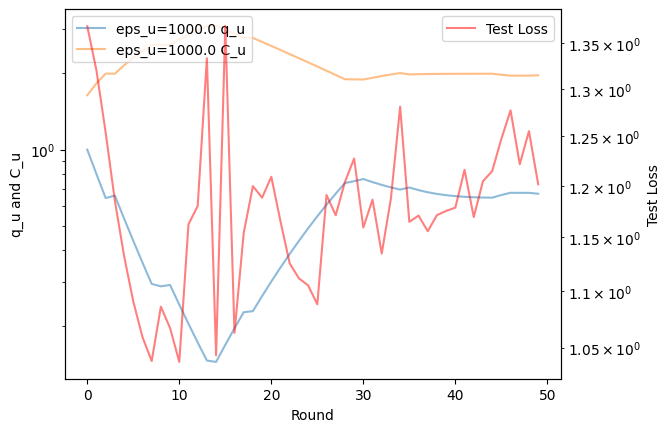

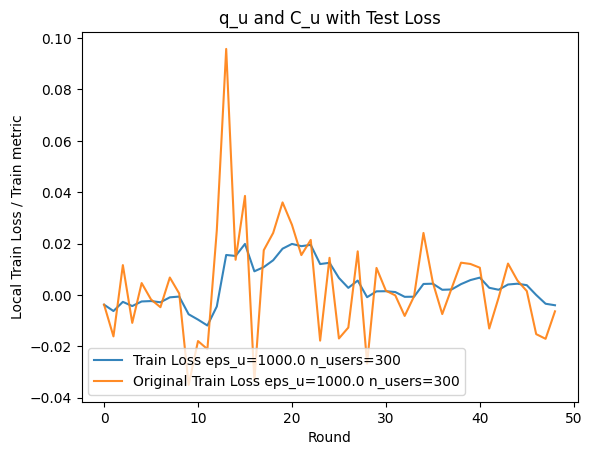

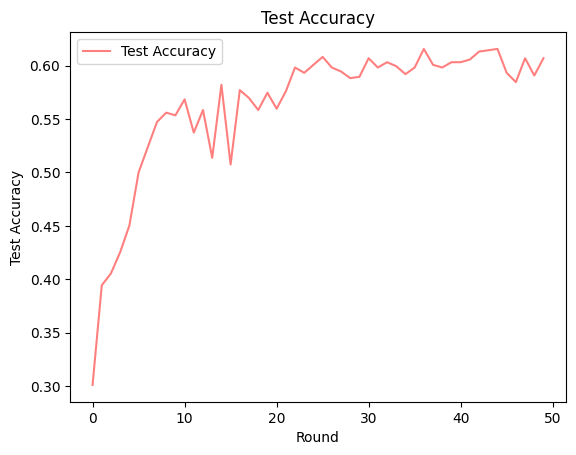

In [28]:
# heart disease with different delta
n_users_list = [300]
sigma = 0.5
epsilon_list = [1000.0]
group_thresholds = epsilon_list
ratio_list = [1.0]
delta = 1e-5
n_round = 50
dataset_name = 'body'
q_step_size = 0.8
validation_ratio = 0.8
times = 2
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online"
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None

logger_set_info()

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=3.0, local_learning_rate=0.001,
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum,
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


n_users: 300
======== TIME: 0 start
[08:23:08 INFO] Start federated learning simulation
[08:25:12 INFO] |----- Global test result of round 0
[08:25:12 INFO] 	 |----- Test/Acc: 0.27114427860696516 (402), Test/Loss: 1.3830209970474243
[08:25:12 INFO] |----- Global valid result of round 0
[08:25:12 INFO] 	 |----- Test/Acc: 0.2445550715619166 (1607), Test/Loss: 5.569769978523254
[08:25:12 INFO] eps_u = 1000.0, diff = -0.0002816915512084961
[08:25:12 INFO] eps_u: 1000.0, original loss_diff: -0.0002816915512084961, (self.momentum[eps_u]: -0.0002816915512084961)
[08:25:12 INFO] Next HP: (Q_u, C_u) = {1000.0: (0.8, 1.5702194490586407)}
[08:25:12 INFO] 

========== end 0-th round training ===========

[08:26:53 INFO] |----- Global test result of round 1
[08:26:53 INFO] 	 |----- Test/Acc: 0.27114427860696516 (402), Test/Loss: 1.379820466041565
[08:26:53 INFO] |----- Global valid result of round 1
[08:26:53 INFO] 	 |----- Test/Acc: 0.2445550715619166 (1607), Test/Loss: 5.551572322845459
[08:26:53

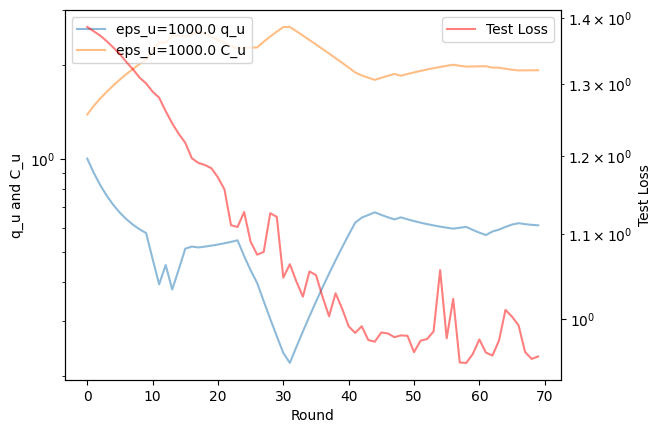

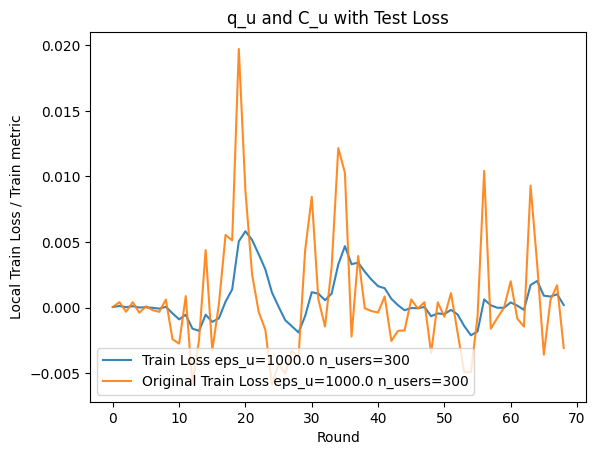

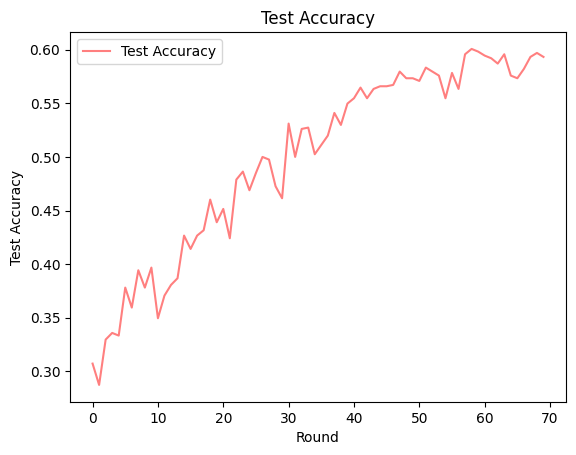

In [31]:
# heart disease with different delta
n_users_list = [300]
sigma = 0.5
epsilon_list = [1000.0]
group_thresholds = epsilon_list
ratio_list = [1.0]
delta = 1e-5
n_round = 70
dataset_name = 'body'
q_step_size = 0.8
validation_ratio = 0.8
times = 2
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online"
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None

logger_set_info()

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=2.0, local_learning_rate=0.0005,
        local_epochs=30, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum,
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


n_users: 300
======== TIME: 0 start
[20:09:22 INFO] Start federated learning simulation
[20:09:43 INFO] |----- Global test result of round 0
[20:09:43 INFO] 	 |----- Test/Acc: 0.46766169154228854 (402), Test/Loss: 1.2880960702896118
[20:09:43 INFO] |----- Global valid result of round 0
[20:09:43 INFO] 	 |----- Test/Acc: 0.46048537647790916 (1607), Test/Loss: 5.090298414230347
[20:09:43 INFO] 

========== end 0-th round training ===========

[20:10:04 INFO] |----- Global test result of round 1
[20:10:04 INFO] 	 |----- Test/Acc: 0.5945273631840796 (402), Test/Loss: 0.9856492280960083
[20:10:04 INFO] |----- Global valid result of round 1
[20:10:04 INFO] 	 |----- Test/Acc: 0.5749844430616055 (1607), Test/Loss: 4.024494886398315
[20:10:04 INFO] 

========== end 1-th round training ===========

[20:10:25 INFO] |----- Global test result of round 2
[20:10:25 INFO] 	 |----- Test/Acc: 0.664179104477612 (402), Test/Loss: 0.8451647162437439
[20:10:25 INFO] |----- Global valid result of round 2
[20

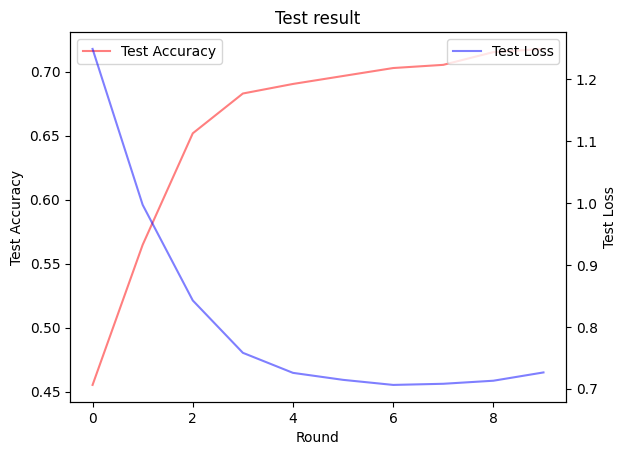

In [21]:
n_users_list = [300]
sigma = 1.0
epsilon_list = [8.0]
group_thresholds = epsilon_list
ratio_list = [1.0]
delta = 1e-5
n_round = 10
dataset_name = 'body'
q_step_size = 0.8
validation_ratio = 0.0
times = 2
random_state = np.random.RandomState(0)
agg_strategy = "DEFAULT"

with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None

logger_set_info()

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=0.5, local_learning_rate=0.001,
        local_epochs=100, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum,
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


IDX:  {5.0: 0}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {5.0: 1}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {5.0: 2}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {5.0: 3}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {5.0: 4}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {5.0: 5}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {5.0: 6}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {5.0: 7}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======

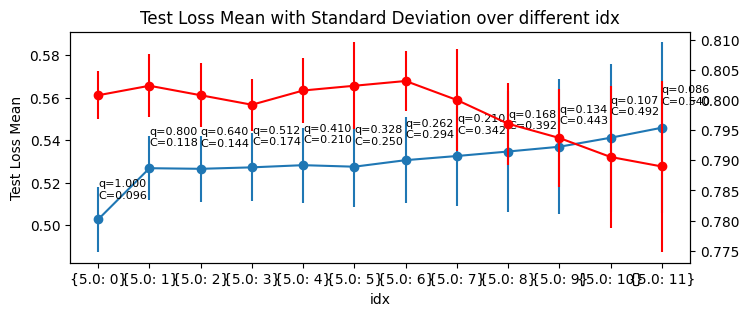

12/23/2023 10:48:11:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


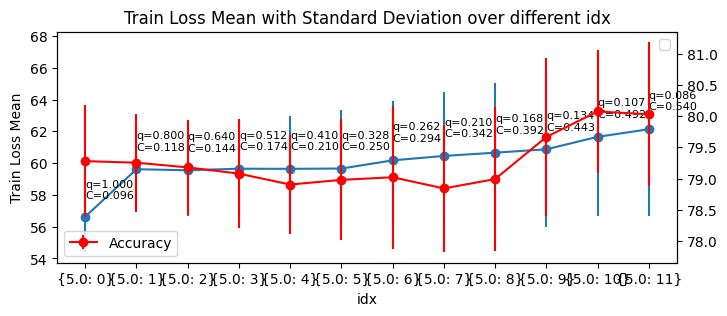

{5.0: 0} 56.62854618479032


In [7]:
sigma = 0.5
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 400
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
validation_ratio = 0.0

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

logger_set_warning()
static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=validation_ratio, train_loss=True)
print(min_idx, min_loss)

IDX:  {0.5: 0}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {0.5: 1}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {0.5: 2}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {0.5: 3}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {0.5: 4}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {0.5: 5}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {0.5: 6}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
IDX:  {0.5: 7}
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======

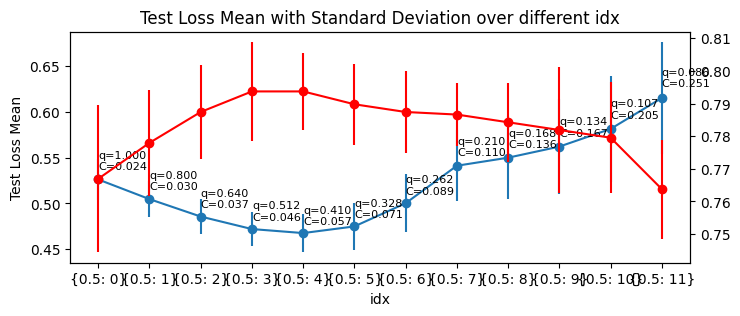

12/22/2023 19:53:32:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


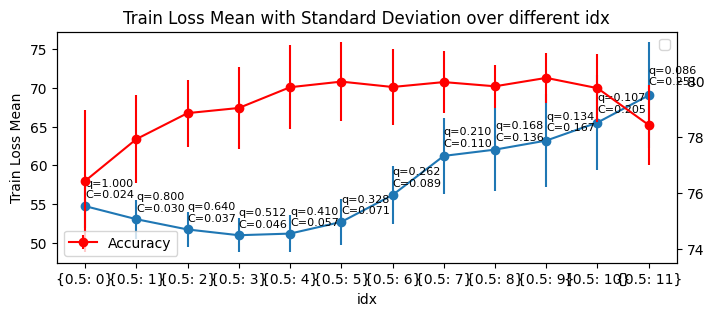

{0.5: 3} 50.962141468717405


In [4]:
sigma = 1.0
epsilon_list = [0.5]
group_thresholds = [0.5]
ratio_list = [1.0]
delta = 1e-5
n_users = 400
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
validation_ratio = 0.0

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

logger_set_warning()
static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=validation_ratio, train_loss=True)
print(min_idx, min_loss)

n_users: 300
======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7686 ± 0.0479 , TEST LOSS: 0.6119 ± 0.1855
VALID ACC: 0.8049 ± 0.0187 , VALID LOSS: 0.5792 ± 0.0684


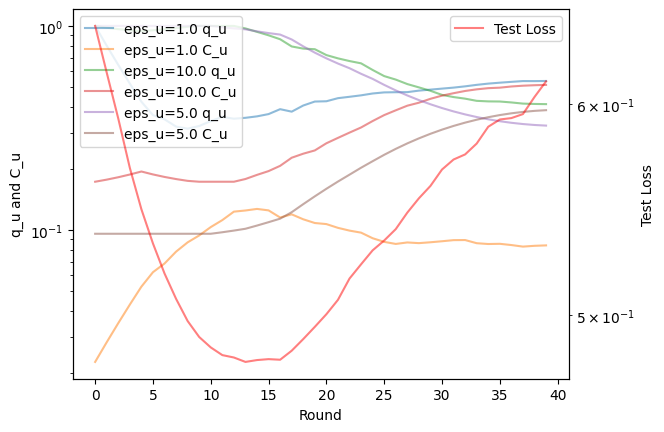

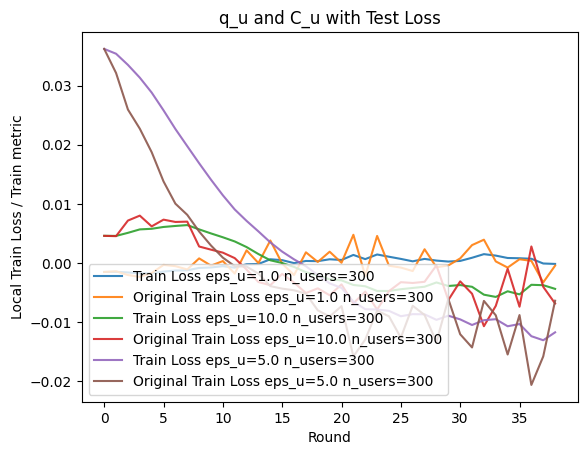

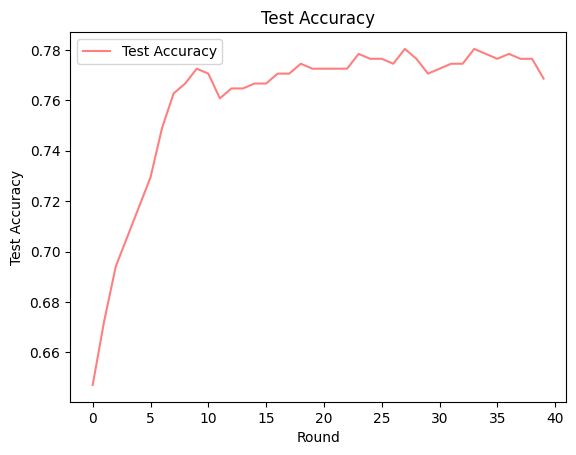

In [5]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.8
times = 10
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online"
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

n_users: 300
======== TIME: 0 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


======== TIME: 1 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


======== TIME: 2 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


======== TIME: 3 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


======== TIME: 4 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


======== TIME: 5 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


======== TIME: 6 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


======== TIME: 7 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


======== TIME: 8 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


======== TIME: 9 start


/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TEST ACC: 0.7745 ± 0.0474 , TEST LOSS: 0.6217 ± 0.2169
VALID ACC: 0.7961 ± 0.0177 , VALID LOSS: 0.5933 ± 0.0684


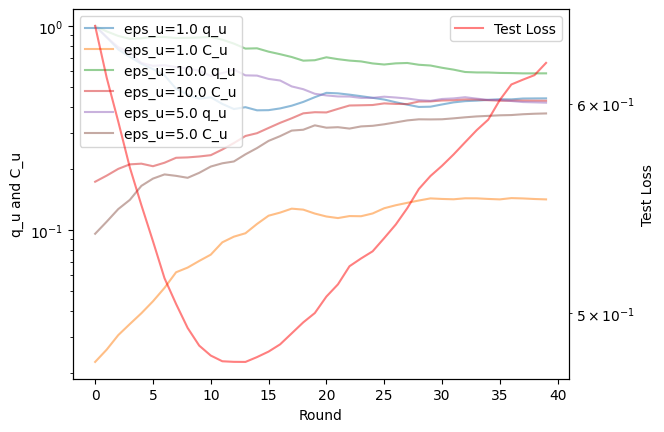

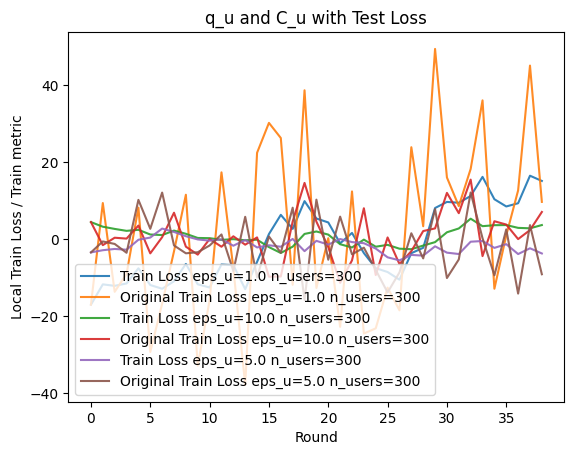

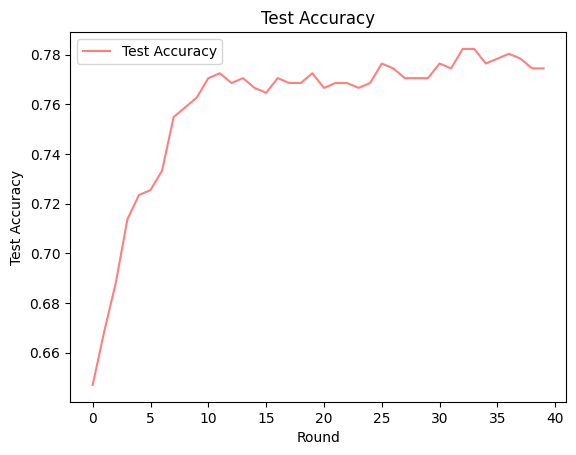

In [8]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.8
times = 10
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)